# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

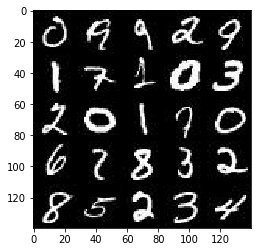

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

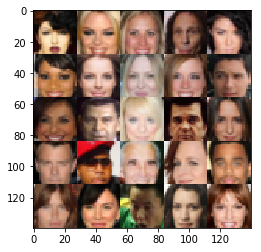

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [43]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    z_input = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learning_rate = tf.placeholder(tf.float32,shape=())
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [44]:
def discriminator(images, reuse=False, alpha = 0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    keep_prob = 0.9
    def my_discriminator_layer(x_inputs,depth,normalized,dropouted):
        layer = tf.layers.conv2d(x_inputs,depth,5,2,padding='same',activation=None)
        if normalized:
            layer1 = tf.layers.batch_normalization(layer,training=normalized)
        layer = tf.maximum(alpha * layer, layer) 
        if dropouted:
            layer = tf.nn.dropout(layer,keep_prob)
        return layer
    
    with tf.variable_scope('discriminator',reuse=reuse):
        #14,14,64
        #d1 = tf.layers.conv2d(images,64,kernel_size=5,strides=2,padding='same')
        #d1 = tf.maximum(alpha * d1, d1)
        
        #7,7,128
        #d2 = tf.layers.conv2d(d1,128,kernel_size=5,strides=2,padding='same')
        #d2 = tf.layers.batch_normalization(d2,training=True)
        #d2 = tf.maximum(alpha * d2, d2)
        
        #4,4,256
        #d3 = tf.layers.conv2d(d2,256,kernel_size=5,strides=2,padding='same')
        #d3 = tf.layers.batch_normalization(d3,training=True)
        #d3 = tf.maximum(alpha * d3,d3)
        
        #2,2,512
        #d4 = tf.layers.conv2d(d3,512,kernel_size=5,strides=2,padding='same')
        #d4 = tf.layers.batch_normalization(d4,training=True)
        #d4 = tf.maximum(alpha * d4, d4)
        d1 = my_discriminator_layer(images,64,True,False)
        d2 = my_discriminator_layer(d1,128,True,True)
        d3 = my_discriminator_layer(d2,256,True,True)
        d4 = my_discriminator_layer(d3,512,True,False)
        d5 = tf.reshape(d4,(-1,2*2*512))
        
        logits = tf.layers.dense(d5,1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [51]:
def generator(z, out_channel_dim, is_train=True, alpha = 0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    def my_generator_layer(inputs,depth,kernal_sizes,stride,paddings='same'):
        layer = tf.layers.conv2d_transpose(inputs,depth,kernel_size=kernal_sizes,strides=stride,padding=paddings,kernel_initializer=xavier)
        layer = tf.layers.batch_normalization(layer,training=is_train)
        layer = tf.maximum(alpha * layer , layer)
        return layer
    xavier = tf.contrib.layers.xavier_initializer_conv2d()
    with tf.variable_scope('generator',reuse= not is_train):
        g0 = tf.layers.dense(z, 7 * 7 * 512,kernel_initializer=xavier)
        g0 = tf.reshape(g0,(-1,7,7,512))
        g1 = tf.layers.batch_normalization(g0,training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        '''
        #7,7,128
        g2 = tf.layers.conv2d_transpose(g1,128,3,strides=2,padding='valid')
        g2 = tf.layers.batch_normalization(g2,training=is_train)
        g2= tf.maximum(alpha * g2, g2)
        
        #14,14,64
        g3 = tf.layers.conv2d_transpose(x2,64,5,strides=2,padding='same')
        g3 = tf.layers.batch_normalization(x3,training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
        
        #28,28,32
        g4 = tf.layers.conv2d_transpose(g3,32,5,strides=2,padding='same')
        g4 = tf.layers.batch_normalization(g4,training=is_train)
        g4 = tf.maximum(alpha * g4, g4)
        '''
        layer1 = my_generator_layer(g1,256,5,2)
        layer2 = my_generator_layer(layer1,128,5,2)
        #28,28,out_channel_dim
        logits = tf.layers.conv2d_transpose(layer2,out_channel_dim,5,strides=1,padding='same')
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [46]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    #Generator生成图片
    g_model_out = generator(input_z,out_channel_dim,is_train=True)
    #real picture from discriminator
    d_real_out,d_real_logits = discriminator(input_real,reuse=False)
    #fake picture from discriminator
    d_fake_out,d_fake_logits = discriminator(g_model_out,reuse=True)
    
    # Generator loss
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_out)))
    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,
                                                                         labels=tf.ones_like(d_real_out)*0.9))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_out)))
    # Discriminator loss (fake + real)
    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [47]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    # Optimizers
    # If we don't include the update ops as dependencies on the train step, the 
    # tf.layers.batch_normalization layers won't update their population statistics,
    # which will cause the model to fail at inference time
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        #训练Discriminator和Generator优化器
        d_loss_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_loss_opt = tf.train.AdamOptimizer(learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_loss_opt, g_loss_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [57]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 100
    print_every = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.3447... Generator Loss: 8.1770
Epoch 1/2... Discriminator Loss: 0.6393... Generator Loss: 7.0658
Epoch 1/2... Discriminator Loss: 0.3594... Generator Loss: 5.0522
Epoch 1/2... Discriminator Loss: 0.3919... Generator Loss: 3.6117
Epoch 1/2... Discriminator Loss: 0.8093... Generator Loss: 1.8579
Epoch 1/2... Discriminator Loss: 1.1475... Generator Loss: 0.8427
Epoch 1/2... Discriminator Loss: 1.0324... Generator Loss: 0.9723
Epoch 1/2... Discriminator Loss: 1.1842... Generator Loss: 0.6976
Epoch 1/2... Discriminator Loss: 1.3604... Generator Loss: 0.4898


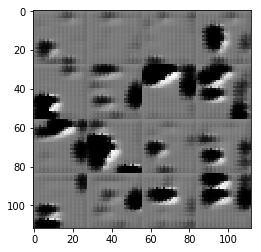

Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 1.9810
Epoch 1/2... Discriminator Loss: 1.0382... Generator Loss: 1.5681
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.2878... Generator Loss: 0.7036
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.1787... Generator Loss: 0.9196
Epoch 1/2... Discriminator Loss: 1.2777... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 1.5573... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.6990
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 1.1393


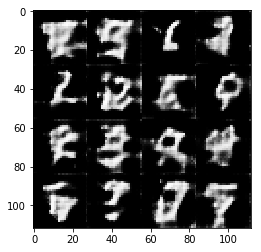

Epoch 1/2... Discriminator Loss: 1.3042... Generator Loss: 0.8349
Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 0.8544
Epoch 1/2... Discriminator Loss: 1.2043... Generator Loss: 1.1582
Epoch 1/2... Discriminator Loss: 1.2491... Generator Loss: 0.8198
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 0.7729
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.2658... Generator Loss: 0.7907
Epoch 1/2... Discriminator Loss: 1.1311... Generator Loss: 1.0798
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.8573
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.4375


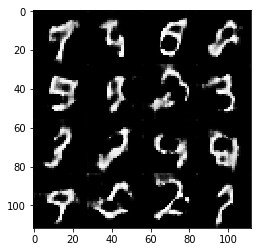

Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 1.0589
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.2223... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 0.9291
Epoch 1/2... Discriminator Loss: 1.0672... Generator Loss: 0.9611
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 1.0575
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.1245
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.3233
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 1.0628


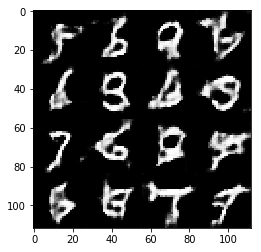

Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.9500
Epoch 1/2... Discriminator Loss: 1.0692... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.2486
Epoch 1/2... Discriminator Loss: 1.2166... Generator Loss: 0.8550
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 1.3199
Epoch 1/2... Discriminator Loss: 1.0796... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.0728... Generator Loss: 1.1083
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 0.8223
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 0.9474


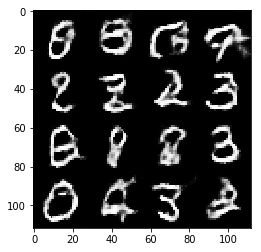

Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 1.2086
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 1.2323
Epoch 1/2... Discriminator Loss: 1.0994... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 1.0196... Generator Loss: 1.2756
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.1746
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.1775


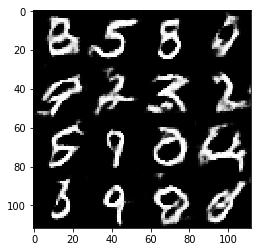

Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8390
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 1.1678
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 1.0031
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 1.1105
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 1.1553
Epoch 1/2... Discriminator Loss: 1.1533... Generator Loss: 1.0351
Epoch 1/2... Discriminator Loss: 0.9595... Generator Loss: 1.2228
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 1.1989
Epoch 1/2... Discriminator Loss: 1.1008... Generator Loss: 0.9664
Epoch 1/2... Discriminator Loss: 1.0736... Generator Loss: 1.2982


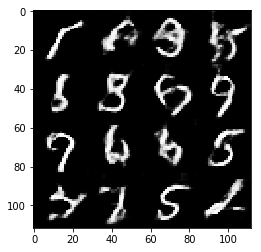

Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.5214
Epoch 1/2... Discriminator Loss: 1.0407... Generator Loss: 1.1321
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.1670
Epoch 1/2... Discriminator Loss: 1.0993... Generator Loss: 1.0692
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 1.1465
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 1.1072
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.2905
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.5757
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.1530


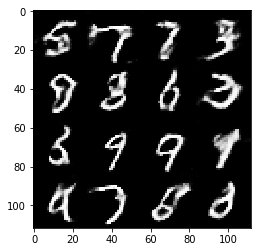

Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.2179
Epoch 1/2... Discriminator Loss: 1.0113... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 1.0430... Generator Loss: 1.2402
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 1.2871
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 1.2057
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 1.1010
Epoch 1/2... Discriminator Loss: 1.0655... Generator Loss: 1.3383
Epoch 1/2... Discriminator Loss: 1.1066... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 1.0267... Generator Loss: 1.4500
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 1.1932


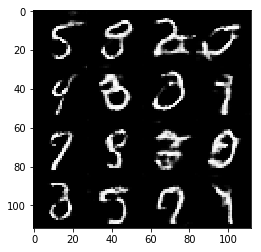

Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.2396
Epoch 1/2... Discriminator Loss: 1.1920... Generator Loss: 0.9282
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 1.2269
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 1.3152
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.1746
Epoch 2/2... Discriminator Loss: 1.0804... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 0.9728... Generator Loss: 1.2489
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 1.1667... Generator Loss: 1.1288
Epoch 2/2... Discriminator Loss: 1.0750... Generator Loss: 1.3473


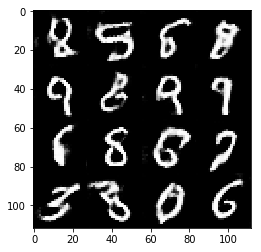

Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.2367
Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.9323
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 1.1191... Generator Loss: 1.1770
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 1.2712
Epoch 2/2... Discriminator Loss: 1.1135... Generator Loss: 1.0430
Epoch 2/2... Discriminator Loss: 1.1077... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 1.2518


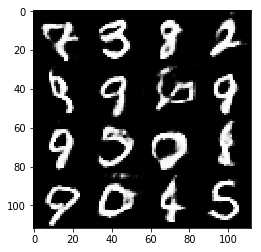

Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 1.2366
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.0025
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 0.9820
Epoch 2/2... Discriminator Loss: 1.0647... Generator Loss: 1.0896
Epoch 2/2... Discriminator Loss: 1.0745... Generator Loss: 1.1424
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.1593
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 1.0215


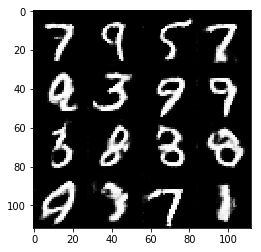

Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.2132
Epoch 2/2... Discriminator Loss: 1.0301... Generator Loss: 1.0220
Epoch 2/2... Discriminator Loss: 1.1090... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 1.2283
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 1.2930
Epoch 2/2... Discriminator Loss: 1.1484... Generator Loss: 1.0371
Epoch 2/2... Discriminator Loss: 1.1172... Generator Loss: 1.1434
Epoch 2/2... Discriminator Loss: 1.1854... Generator Loss: 1.0639
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 1.2333
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 1.1914


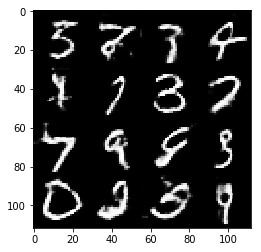

Epoch 2/2... Discriminator Loss: 1.1336... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.2697
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 1.0181
Epoch 2/2... Discriminator Loss: 1.0717... Generator Loss: 1.1252
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.0542
Epoch 2/2... Discriminator Loss: 1.1015... Generator Loss: 1.1477
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 1.0246
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.8751
Epoch 2/2... Discriminator Loss: 1.1476... Generator Loss: 1.0284
Epoch 2/2... Discriminator Loss: 1.1245... Generator Loss: 1.0974


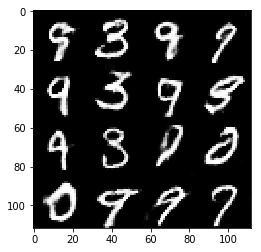

Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 1.0959
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.9365
Epoch 2/2... Discriminator Loss: 1.1133... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.0789... Generator Loss: 1.0568
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 1.0952... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 1.0688


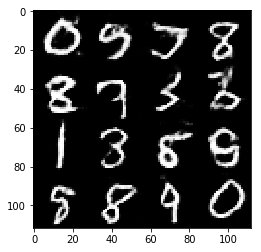

Epoch 2/2... Discriminator Loss: 1.0520... Generator Loss: 1.1018
Epoch 2/2... Discriminator Loss: 1.2819... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.0891... Generator Loss: 0.9800
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 1.0770
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.1468
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 1.0262
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.9836
Epoch 2/2... Discriminator Loss: 1.0363... Generator Loss: 1.1554
Epoch 2/2... Discriminator Loss: 1.1355... Generator Loss: 1.0595


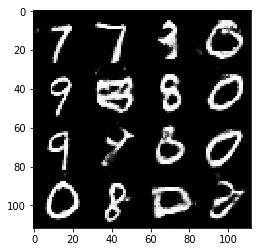

Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 1.2318
Epoch 2/2... Discriminator Loss: 1.0415... Generator Loss: 1.3202
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 0.9553... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1373
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.1512
Epoch 2/2... Discriminator Loss: 1.0565... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.0843... Generator Loss: 1.0793
Epoch 2/2... Discriminator Loss: 1.0548... Generator Loss: 1.1467
Epoch 2/2... Discriminator Loss: 1.1420... Generator Loss: 0.9653


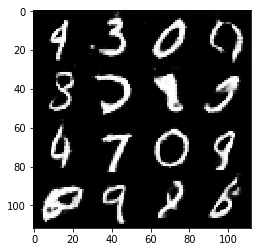

Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.9656
Epoch 2/2... Discriminator Loss: 1.0736... Generator Loss: 1.0299
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 1.2232
Epoch 2/2... Discriminator Loss: 1.1221... Generator Loss: 1.1604
Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 1.0217
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.9974
Epoch 2/2... Discriminator Loss: 1.0552... Generator Loss: 1.1231
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.1972
Epoch 2/2... Discriminator Loss: 1.2286... Generator Loss: 0.9739


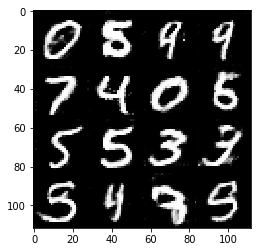

Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.0725... Generator Loss: 1.1444
Epoch 2/2... Discriminator Loss: 1.0181... Generator Loss: 1.1618
Epoch 2/2... Discriminator Loss: 1.1853... Generator Loss: 0.9695
Epoch 2/2... Discriminator Loss: 1.1351... Generator Loss: 1.0170
Epoch 2/2... Discriminator Loss: 1.0781... Generator Loss: 1.2189
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 1.3901
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 1.0594


In [58]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 0.4163... Generator Loss: 8.6392
Epoch 1/1... Discriminator Loss: 0.4274... Generator Loss: 17.4978
Epoch 1/1... Discriminator Loss: 0.5667... Generator Loss: 3.3659
Epoch 1/1... Discriminator Loss: 0.6318... Generator Loss: 5.5259
Epoch 1/1... Discriminator Loss: 0.8841... Generator Loss: 1.4646
Epoch 1/1... Discriminator Loss: 0.6527... Generator Loss: 5.0531
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 3.8398
Epoch 1/1... Discriminator Loss: 0.3768... Generator Loss: 4.8541
Epoch 1/1... Discriminator Loss: 0.6133... Generator Loss: 2.7393


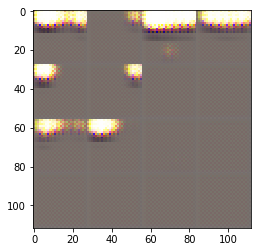

Epoch 1/1... Discriminator Loss: 0.5816... Generator Loss: 3.8804
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 2.9730
Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 2.4690
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 4.5066
Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.9182
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 2.8428
Epoch 1/1... Discriminator Loss: 0.9081... Generator Loss: 2.1355
Epoch 1/1... Discriminator Loss: 0.7493... Generator Loss: 1.9902
Epoch 1/1... Discriminator Loss: 0.7045... Generator Loss: 2.2019
Epoch 1/1... Discriminator Loss: 2.2721... Generator Loss: 0.4352


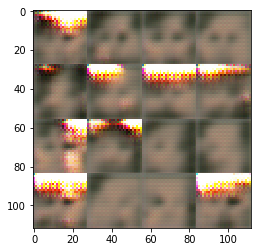

Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 2.1072
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0170
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 2.6370
Epoch 1/1... Discriminator Loss: 0.9135... Generator Loss: 1.5111
Epoch 1/1... Discriminator Loss: 1.0204... Generator Loss: 1.2448
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 0.8500... Generator Loss: 1.3184
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.2657
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 2.2184


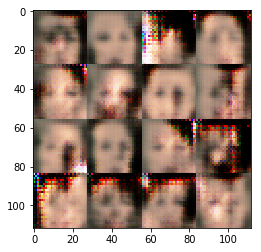

Epoch 1/1... Discriminator Loss: 1.3290... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.1518
Epoch 1/1... Discriminator Loss: 1.2404... Generator Loss: 1.2184
Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.8831
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.6293
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 1.9250
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.5389


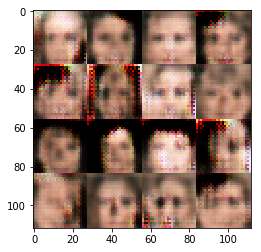

Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.6216
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.4323
Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.5349... Generator Loss: 1.8498
Epoch 1/1... Discriminator Loss: 1.1459... Generator Loss: 1.0995
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.7671


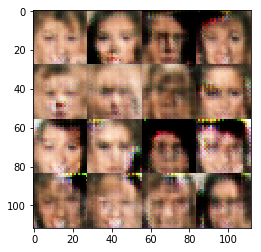

Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0010
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 1.2501
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 1.0079


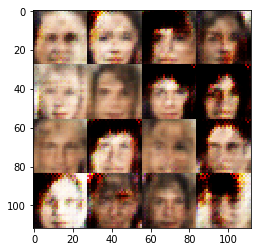

Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 1.2461
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.5595
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.9147
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 2.3458
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.8072
Epoch 1/1... Discriminator Loss: 1.1217... Generator Loss: 1.0766


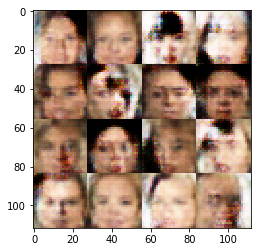

Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 1.0576
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.3674
Epoch 1/1... Discriminator Loss: 1.1563... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.8785
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9948


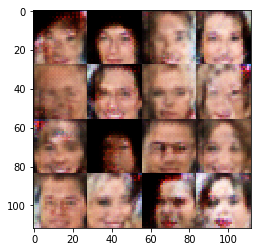

Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.9313
Epoch 1/1... Discriminator Loss: 1.1415... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.6207... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 0.9443
Epoch 1/1... Discriminator Loss: 1.1265... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.9984
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 1.6897
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8067


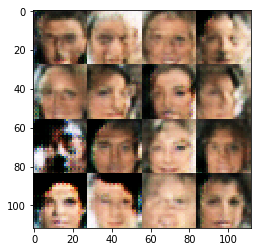

Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.0884
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 1.2931
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.3540
Epoch 1/1... Discriminator Loss: 1.3273... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.2098... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.2291... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 1.0275


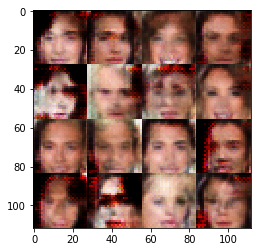

Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.9642
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9879
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.1465... Generator Loss: 0.9742
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.1646... Generator Loss: 1.3031
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.1953... Generator Loss: 0.9176


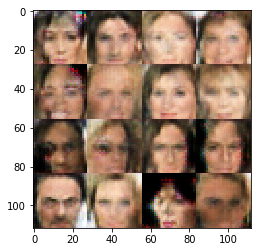

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 1.0756
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.9859
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 1.0269


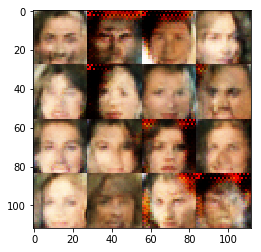

Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2019... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.9375
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.9741
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8473


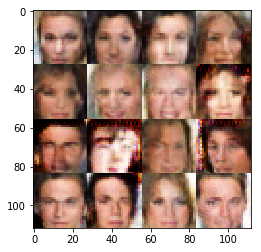

Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.8611
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.2314... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 1.2224
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.0358
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.8389


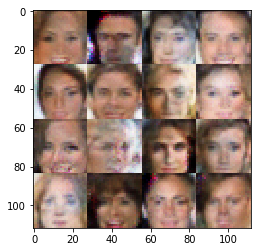

Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.9082
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8498
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.1906... Generator Loss: 0.8645
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8492
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9219


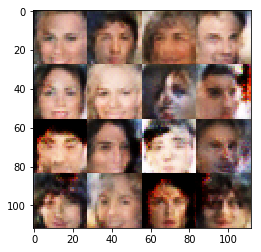

Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.9438
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 1.2849... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.8612
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8973


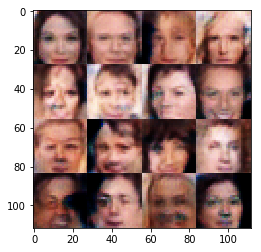

Epoch 1/1... Discriminator Loss: 1.2292... Generator Loss: 1.6784
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.9512
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8622
Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.9340


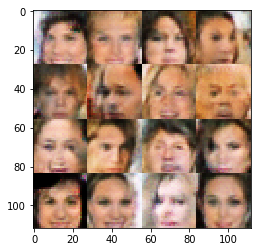

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.3048... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.7888


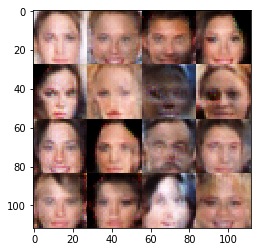

Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8960
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8613
Epoch 1/1... Discriminator Loss: 1.1675... Generator Loss: 0.9239
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.9381


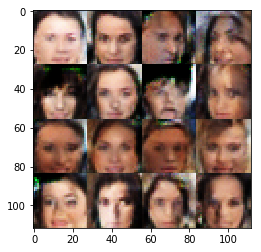

Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.8226
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.9138
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3153... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7820


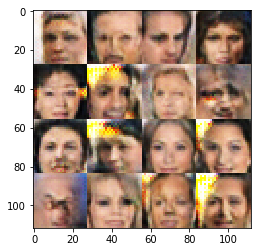

Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.2071... Generator Loss: 1.0113
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8738


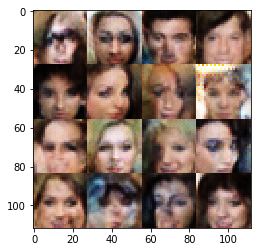

Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.2400... Generator Loss: 0.8878
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.9530
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9653
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.8500


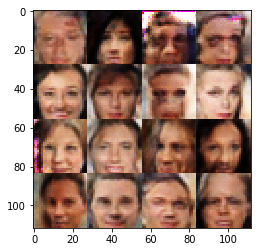

Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.9149
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.9927
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8809
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.9906
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.9520


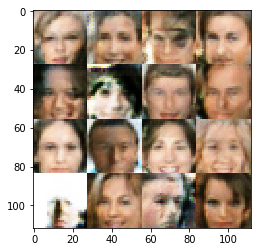

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.2360... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.8286


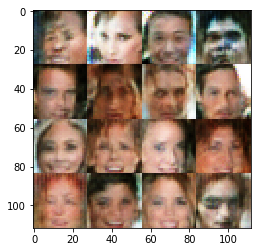

Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.9278
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.9191
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.7626


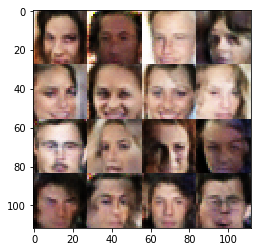

Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8686
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.4069
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.9632
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.2274... Generator Loss: 0.8554


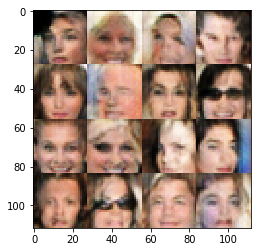

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7055
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9077
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.1604... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.8423


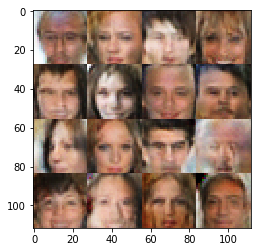

Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3398... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8896
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.8552


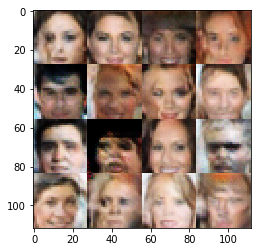

Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8175
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.9208
Epoch 1/1... Discriminator Loss: 1.2495... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8237


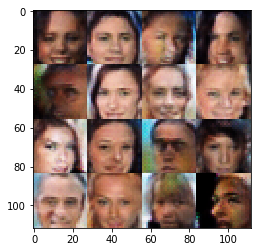

Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.8250
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.8732


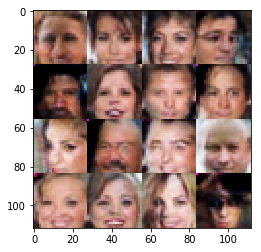

Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 0.8912
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.0764... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2003... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.2476... Generator Loss: 0.8847


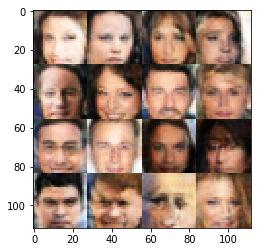

Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.8945
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.1950... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9292


In [59]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。